In [55]:
import fireducks.pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn import metrics
from ast import increment_lineno
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
import numpy as np
import pickle

### Limpeza e Tratamento dos Dados

In [56]:
df_clean = pd.read_csv("fraud_data.csv")

In [57]:
df_clean.head()

,trans_date_trans_time,merchant,category,amt,city,state,lat,long,city_pop,job,dob,trans_num,merch_lat,merch_long,is_fraud
0,04-01-2019 00:58,"""Stokes, Christiansen and Sipes""",grocery_net,14.37,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,a3806e984cec6ac0096d8184c64ad3a1,65.654142,-164.722603,1
1,04-01-2019 15:06,Predovic Inc,shopping_net,966.11,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,a59185fe1b9ccf21323f581d7477573f,65.468863,-165.473127,1
2,04-01-2019 22:37,Wisozk and Sons,misc_pos,49.61,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,86ba3a888b42cd3925881fa34177b4e0,65.347667,-165.914542,1
3,04-01-2019 23:06,Murray-Smitham,grocery_pos,295.26,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,3a068fe1d856f0ecedbed33e4b5f4496,64.445035,-166.080207,1
4,04-01-2019 23:59,Friesen Lt,health_fitness,18.17,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,891cdd1191028759dc20dc224347a0ff,65.447094,-165.446843,1


In [58]:
# Converter a coluna 'is_fraud' para numérico (int), tratando possíveis erros
df_clean['is_fraud'] = pd.to_numeric(df_clean['is_fraud'], errors='coerce').fillna(0).astype(int)

# Verificar novamente os valores únicos para confirmar a conversão
df_clean['is_fraud'].unique()

array([1, 0])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14446 entries, 0 to 14445
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   trans_date_trans_time  14446 non-null  object 
 1   merchant               14446 non-null  object 
 2   category               14446 non-null  object 
 3   amt                    14446 non-null  float64
 4   city                   14446 non-null  object 
 5   state                  14446 non-null  object 
 6   lat                    14446 non-null  float64
 7   long                   14446 non-null  float64
 8   city_pop               14446 non-null  int64  
 9   job                    14446 non-null  object 
 10  dob                    14446 non-null  object 
 11  trans_num              14446 non-null  object 
 12  merch_lat              14446 non-null  float64
 13  merch_long             14446 non-null  float64
 14  is_fraud               14446 non-null  int64  
dtypes:

Nas próximas duas células foram tratado os campos de datas, na análise exploratória pode-se perceber que os peírodos de fraude eram maiores na madrugada então criei o campo com os períodos e será avaliado outros campos de epócas do ano com os meses.

In [59]:
def determinar_periodo_do_dia(hora):
    if 0 <= hora < 6:
        return 'Madrugada'
    elif 6 <= hora < 12:
        return 'Manha'
    elif 12 <= hora < 18:
        return 'Tarde'
    else:
        return 'Noite'

In [60]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import numpy as np

# Copiar o dataset original
# df_clean = df

# Remover colunas
df_clean = df_clean.drop(columns=["trans_num", "merchant", "city", "state", "job"])

# Converter trans_date_trans_time para datetime e criar novas features
df_clean['trans_date_trans_time'] = pd.to_datetime(df_clean['trans_date_trans_time'], format='%d-%m-%Y %H:%M')
df_clean['transaction_hour'] = df_clean['trans_date_trans_time'].dt.hour
df_clean['transaction_day'] = df_clean['trans_date_trans_time'].dt.day
df_clean['transaction_month'] = df_clean['trans_date_trans_time'].dt.month
df_clean['transaction_weekday'] = df_clean['trans_date_trans_time'].dt.weekday
df_clean['transaction_period'] = df_clean['transaction_hour'].apply(determinar_periodo_do_dia)
df_clean = df_clean.drop(columns=['trans_date_trans_time'])

# Calcular idade com base em 'dob'
# df_clean['dob'] = pd.to_datetime(df_clean['dob'], format='%d-%m-%Y')
# df_clean['age'] = (pd.to_datetime('today') - df_clean['dob']).dt.days // 365
df_clean = df_clean.drop(columns=['dob'])

No campo montante da transação na análise exploratóra percebeu-se que a maioria das transações que eram de um valor baixo, então aplicou-se escala logaritma para reduzir o impacto de transações muito altas.

In [61]:
df_clean['amt'] = np.log1p(df_clean['amt'])

Foi optado por criar dummies para as colunas para ajustar as entradas com o modelo.

In [62]:
# Usar pd.get_dummies para criar variáveis dummies
# df_clean = pd.get_dummies(df_clean, columns= ['category', 'transaction_period', 'transaction_month'], drop_first=False)
df_clean = pd.get_dummies(df_clean, columns= ['category', 'transaction_month'], drop_first=False)
df_clean.head()

,amt,lat,long,city_pop,merch_lat,merch_long,is_fraud,transaction_hour,transaction_day,transaction_weekday,...,transaction_month_3,transaction_month_4,transaction_month_5,transaction_month_6,transaction_month_7,transaction_month_8,transaction_month_9,transaction_month_10,transaction_month_11,transaction_month_12
0,2.732418,64.7556,-165.6723,145,65.654142,-164.722603,1,0,4,4,...,False,False,False,False,False,False,False,False,False,False
1,6.874312,64.7556,-165.6723,145,65.468863,-165.473127,1,15,4,4,...,False,False,False,False,False,False,False,False,False,False
2,3.924149,64.7556,-165.6723,145,65.347667,-165.914542,1,22,4,4,...,False,False,False,False,False,False,False,False,False,False
3,5.691237,64.7556,-165.6723,145,64.445035,-166.080207,1,23,4,4,...,False,False,False,False,False,False,False,False,False,False
4,2.953347,64.7556,-165.6723,145,65.447094,-165.446843,1,23,4,4,...,False,False,False,False,False,False,False,False,False,False


In [63]:
df_clean = pd.get_dummies(df_clean, columns= ['transaction_period'], drop_first=False)

No gráfico abaixo, ele foi montado e casos seja executado nessa sequência irá quebrar, ele eestá aqui para mostrar a influência de campo no modelo, através disso foram excluídas algumas colunas para deixar mais enxuto o modelo e excluir colunas com pouca relevância.

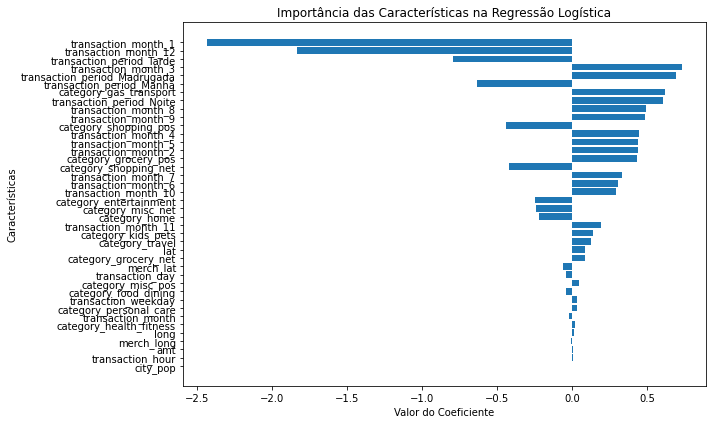

In [109]:
quantidade_parametros = 40

coeficientes = model.coef_[0]
nomes_caracteristicas = X.columns

# Ordenar as características pelo valor absoluto dos coeficientes
indices_ordenados = np.argsort(np.abs(coeficientes))

plt.figure(figsize=(10, 6))
plt.barh(range(quantidade_parametros), coeficientes[indices_ordenados[-quantidade_parametros:]], align='center', color='#1f77b4')
plt.yticks(range(quantidade_parametros), [nomes_caracteristicas[i] for i in indices_ordenados[-quantidade_parametros:]])
plt.xlabel('Valor do Coeficiente')
plt.ylabel('Características')
plt.title('Importância das Características na Regressão Logística')
plt.tight_layout()
plt.show()

Através do gráfico acima foram excluidas as colunas abaixo.

In [65]:
exclude = [
    "city_pop",
    "transaction_hour",
    "merch_long",
    "long",
    "category_health_fitness",
    "category_personal_care",
    "transaction_weekday",
    "category_food_dining",
    "category_misc_pos",
    "transaction_day",
    "merch_lat",
    "category_grocery_net",
    "lat",
]

In [66]:
df_clean = df_clean.drop(columns=exclude, axis=1)

In [67]:
df_clean.head()

,amt,is_fraud,category_entertainment,category_gas_transport,category_grocery_pos,category_home,category_kids_pets,category_misc_net,category_shopping_net,category_shopping_pos,...,transaction_month_7,transaction_month_8,transaction_month_9,transaction_month_10,transaction_month_11,transaction_month_12,transaction_period_Madrugada,transaction_period_Manha,transaction_period_Noite,transaction_period_Tarde
0,2.732418,1,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1,6.874312,1,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
2,3.924149,1,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3,5.691237,1,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,2.953347,1,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [68]:
# Separação de entrada e saída dos dados
X = df_clean.drop(columns=['is_fraud'])
y = df_clean['is_fraud']

In [15]:
df_clean.head()

,amt,is_fraud,category_entertainment,category_gas_transport,category_grocery_pos,category_home,category_kids_pets,category_misc_net,category_shopping_net,category_shopping_pos,category_travel,transaction_period_Madrugada,transaction_period_Manhã,transaction_period_Noite,transaction_period_Tarde
0,2.732418,1,False,False,False,False,False,False,False,False,False,True,False,False,False
1,6.874312,1,False,False,False,False,False,False,True,False,False,False,False,False,True
2,3.924149,1,False,False,False,False,False,False,False,False,False,False,False,True,False
3,5.691237,1,False,False,True,False,False,False,False,False,False,False,False,True,False
4,2.953347,1,False,False,False,False,False,False,False,False,False,False,False,True,False


In [69]:
# Separa dos conjuntos de treino e testes
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=13)

### Regressão Logística

Os hiperparâmetros utilizados no modelo abaixo foram variados e essa foi a configuração final:
max_iter=100, ela foi variado para mais e menos e esse foi um balanço encontrado sem muitas iterações para não gerar overftng e nem tão poucas pro underfiting;
random_state=42, para garantir a reprodutibilidade dos treinamentos;
class_weight='balanced', hiperparâmetro para melhorar treinamento de datasets desbalanceados;
C=0.1, para evitar o risco de overfiting;
solver='liblinear'funcionou melhor para o dataset, por ser um dataset menor e baixa dimensionalidade.

In [70]:
# Criação do modelo e definição dos hiperparâmetros
lr = LogisticRegression(max_iter=100, random_state=42, class_weight='balanced', C=0.1, solver='liblinear')
model = lr.fit(x_train, y_train)

#### Avaliação Modelo
Na curva ROC é possível ver que ela está próxima ao canto esquerdo oque mostra que o modelo separa bem as classes. Um AUC de 0,962 que mostra um excelente desempenho. Será ajustado o treshold de classificação do modelo baseado na curva roc.

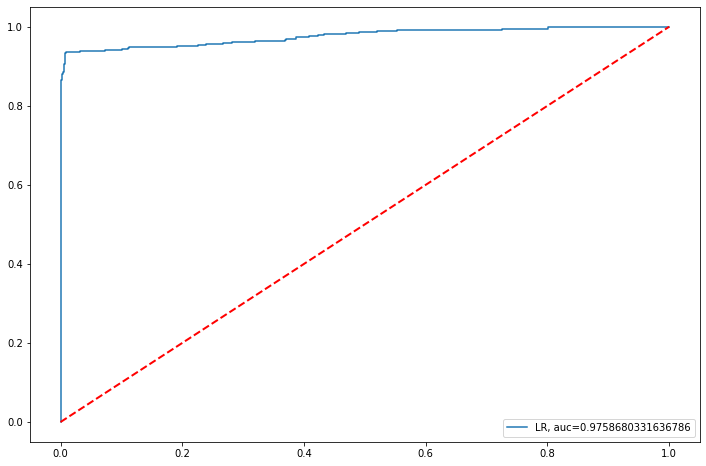

In [71]:
y_pred_proba = model.predict_proba(x_test)[::, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.rcParams['figure.figsize'] = (12., 8.)
plt.plot(fpr, tpr, label ="LR, auc="+str(auc))
plt.plot([0,1], [0,1], color='red', lw=2, linestyle ='--')
plt.legend(loc=4)

Abaixo o gráfico da importância de cada parâmetro no modelo, os a direita influênciam mais para uma detecção de fraude, poderiam ser trabalhados ainda nos parâmetros de entrada, mas o foco vai ser na solução completa.

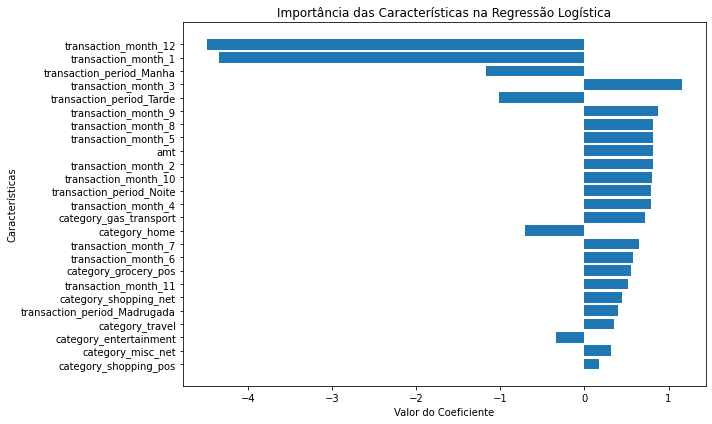

In [73]:
quantidade_parametros = 25

coeficientes = model.coef_[0]
nomes_caracteristicas = X.columns

# Ordenar as características pelo valor absoluto dos coeficientes
indices_ordenados = np.argsort(np.abs(coeficientes))

plt.figure(figsize=(10, 6))
plt.barh(range(quantidade_parametros), coeficientes[indices_ordenados[-quantidade_parametros:]], align='center', color='#1f77b4')
plt.yticks(range(quantidade_parametros), [nomes_caracteristicas[i] for i in indices_ordenados[-quantidade_parametros:]])
plt.xlabel('Valor do Coeficiente')
plt.ylabel('Características')
plt.title('Importância das Características na Regressão Logística')
plt.tight_layout()
plt.show()

#### Avaliação Dataset Testes

##### Treshold 50
Com um treshold de 50% padrão na classificação.
Nas métricas abaixo foram utilizadas como parâmetro a recall e F1. 
A recall alta como é o caso 0.86 significa que o modelo está detectando bem as fraudes.
E a F1 é que o modelo está em bom equilibrio entre precisão e recall, para que classifique bem as fraudes mas não gere uma grande quantidade de Falsos Positivos(nesse caso pela matriz de confusão 96).
Os resultados encontrados foram condizentes com literatura encontrada em artigos científicos.

In [74]:
y_pred = model.predict(x_test)
print('Recall: ', metrics.recall_score(y_test, y_pred))
print('F1: ', metrics.f1_score(y_test, y_pred))
print('Acurácia: ', metrics.accuracy_score(y_test, y_pred))
print('Precisão: ', metrics.precision_score(y_test, y_pred))

Recall:  0.9340463458110517
F1:  0.9357142857142857
Acurácia:  0.9833871712044301
Precisão:  0.9373881932021467


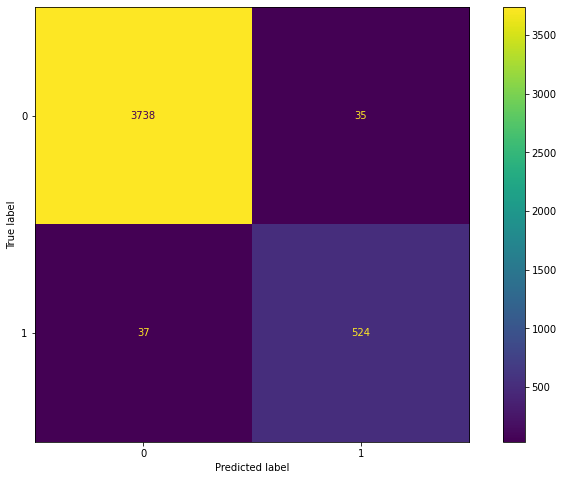

In [75]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

##### Ajustes de Treshold

Para encontrar o threshold foram utilizados dois métodos, o primeiro como um vetor variando o mesmo e dando a pontuação dde F1 e recall. E o segundo é a métrica geométrica que maximiza a detecção de Verdadeiros Positivos e minimiza os Falsos Positivos.
Foi escolhido do segundo método um valor de 0.496, mas casos em próximas discussões for escolhido por levar em considerção diminuir um campo pode ser alterado. 
Aqui também as métricas condizem com oque é encontrada na literatura.

In [76]:
from sklearn.metrics import f1_score, recall_score

# Testar vários thresholds e avaliar o F1-Score
thresholds = np.arange(0.1, 0.9, 0.05)
for threshold in thresholds:
    y_pred_class = (y_pred_proba > threshold).astype(int)
    f1 = f1_score(y_test, y_pred_class)
    recall = recall_score(y_test, y_pred_class)
    print(f"Threshold: {threshold:.2f}, F1-Score: {f1:.2f}, recall: {recall:.2f}")


Threshold: 0.10, F1-Score: 0.44, recall: 0.96
Threshold: 0.15, F1-Score: 0.51, recall: 0.96
Threshold: 0.20, F1-Score: 0.57, recall: 0.95
Threshold: 0.25, F1-Score: 0.62, recall: 0.95
Threshold: 0.30, F1-Score: 0.72, recall: 0.94
Threshold: 0.35, F1-Score: 0.81, recall: 0.94
Threshold: 0.40, F1-Score: 0.86, recall: 0.94
Threshold: 0.45, F1-Score: 0.90, recall: 0.94
Threshold: 0.50, F1-Score: 0.94, recall: 0.93
Threshold: 0.55, F1-Score: 0.94, recall: 0.93
Threshold: 0.60, F1-Score: 0.93, recall: 0.90
Threshold: 0.65, F1-Score: 0.92, recall: 0.89
Threshold: 0.70, F1-Score: 0.92, recall: 0.88
Threshold: 0.75, F1-Score: 0.92, recall: 0.86
Threshold: 0.80, F1-Score: 0.90, recall: 0.83
Threshold: 0.85, F1-Score: 0.89, recall: 0.81


In [77]:
from sklearn.metrics import roc_curve

# Calcular FPR, TPR e thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Encontrar o threshold com o menor FPR e maior TPR
gmeans = np.sqrt(tpr * (1-fpr))
best_threshold = thresholds[gmeans.argmax()]
print("Melhor Threshold (ROC):", best_threshold)


Melhor Threshold (ROC): 0.49667967234053234


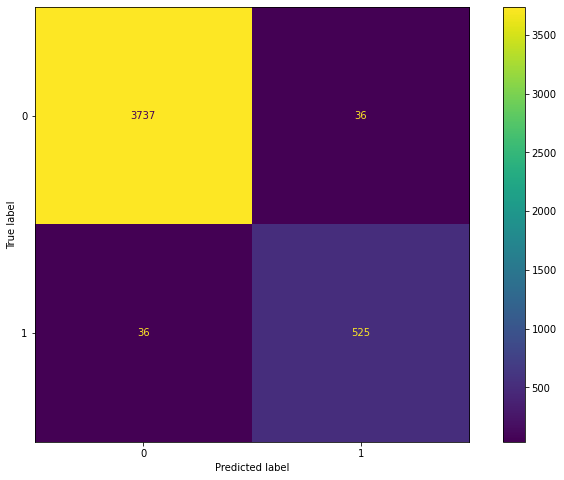

In [78]:
y_pred_proba = model.predict_proba(x_test)[:, 1]
threshold = 0.496
y_pred_class = (y_pred_proba > threshold).astype(int)
cm = confusion_matrix(y_test, y_pred_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [79]:
print('Recall: ', metrics.recall_score(y_test, y_pred_class))
print('F1: ', metrics.f1_score(y_test, y_pred_class))
print('Acurácia: ', metrics.accuracy_score(y_test, y_pred_class))
print('Precisão: ', metrics.precision_score(y_test, y_pred_class))

Recall:  0.9358288770053476
F1:  0.9358288770053476
Acurácia:  0.9833871712044301
Precisão:  0.9358288770053476


In [50]:
# Exportar artefato
meu_arquivo = open('modelo_regressao_v0112.pkl',  'wb')

pickle.dump(model, meu_arquivo)
meu_arquivo.close()